### Change of Mind
#### Do the change of mind trials have less remote theta representation while the animal is going outbound?

Method: For each change of mind trial, find the remote representation on home arm (1) before the animal first made a (half-baked) choice.  (2) when the animal is moving > 5 cm/s and facing out bound. 
Then do the same for a neighboring trial.


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from scipy import linalg
import os
import pickle
import matplotlib.pyplot as plt
from ripple_detection.core import segment_boolean_series

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, RawPosition, IntervalLinearizedPosition, TrackGraph

[2025-03-22 11:10:24,925][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-03-22 11:10:24,965][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [30]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,EpochPos,MUA,get_linearization_map,TrialChoiceChangeofMind
from spyglass.shijiegu.decodeHelpers import runSessionNames
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking,select_subset_helper
from spyglass.shijiegu.changeOfMind import (find_turnaround_time, findProportion,
            find_trials, load_epoch_data_wrapper, find_direction, find_trials_animal)
from spyglass.shijiegu.changeOfMind_triggered import (turnaround_triggered_position,
            turnaround_triggered_decode, find_triggered_animal, find_large_position_minus_decode_trials)
from spyglass.shijiegu.changeOfMind_remote import find_remote_theta_animal, find_triggered_session, do_GLM
from spyglass.shijiegu.load import load_decode

In [259]:
def tally_total_num(day_sessions, trials, proportion):
    """calculate how many change of mind trials per day, and how many trials in total per day."""
    day = "" #initialize
    
    remote_num_all = {}
    total_num_all = {}
    for day_session_ind in range(len(day_sessions)):
        day_session = day_sessions[day_session_ind]
        trials_with_remote = np.unique(trials[day_session_ind])
        
        nwb_copy_file_name = day_session[0]
        session_name = day_session[1]
    
        key={'nwb_file_name':nwb_copy_file_name,'epoch':int(session_name[:2]),"proportion": str(proportion)}
    
        # tally total number of trials on this day
        log=(TrialChoiceChangeofMind & key).fetch1('change_of_mind_info')
        log_df=pd.read_pickle(log)

        if nwb_copy_file_name[5:13] != day:
            day = nwb_copy_file_name[5:13]
            remote_num = len(np.unique(trials_with_remote))
            total_num = len(log_df.index[log_df.change_of_mind])
        else:
            remote_num += len(np.unique(trials_with_remote))
            remote_num_all[day] = remote_num

            total_num += len(log_df.index[log_df.change_of_mind])
            total_num_all[day] = total_num
            
    
    return remote_num_all, total_num_all

In [260]:
(day_sessions, trials, time_intervals, arm_identities,trial_info)  = {},{},{},{},{}

(day_sessions_nearby, trials_nearby, time_intervals_nearby,
 arm_identities_nearby, trial_info_nearby) = ({}, {}, {}, {}, {})

### for debug use

In [ ]:
key = {"nwb_file_name":'lewis20240110_.nwb',
       "epoch":2,
       "proportion":str(0.05)}
log_df = pd.read_pickle((TrialChoiceChangeofMind & key).fetch1("change_of_mind_info"))

# debug end

In [274]:
animal = 'Lewis'
animal_save_name = 'Lewis1'

dates_to_plot = ['20240102','20240103','20240104','20240105','20240106','20240107','20240108','20240109',
                 '20240110','20240113','20240114']

proportion = 0.1

(day_sessions[animal_save_name],trials[animal_save_name],
 time_intervals[animal_save_name],arm_identities[animal_save_name],trial_info[animal_save_name]) = find_remote_theta_animal(
    animal, dates_to_plot, proportion = proportion, delta_t_minus = 1, delta_t_plus = 3, max_flag = False,
    nearby = False, # use nearby trial's outbound or inbound
    home = True
    )


(day_sessions_nearby[animal_save_name],trials_nearby[animal_save_name],
 time_intervals_nearby[animal_save_name],arm_identities_nearby[animal_save_name],trial_info_nearby[animal_save_name]
) = find_remote_theta_animal(
    animal, dates_to_plot, proportion = proportion, delta_t_minus = 1,delta_t_plus = 3, max_flag = False,
    nearby = True, # use nearby trial's outbound or inbound
    home = True
    )

[14:20:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240102_.nwb
lewis20240103_.nwb
lewis20240104_.nwb
lewis20240105_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:20:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704480410.9305322], [1704480438.7225218], [1704480548.30448], [1704480699.020423], [1704480769.3003962], [1704480949.240328], [1704481043.5962923, 1704481045.5162916], [1704481138.1982565, 1704481142.322255], [1704481446.2081397], [1704481545.218102, 1704481547.6661012, 1704481549.0541005], [1704481570.1540926, 1704481573.2140915], [1704481679.368051, 1704481685.046049, 1704481691.3660467], [1704481736.5840294], [1704482025.24792, 1704482026.8799193], [1704482239.7578387], [1704482412.3897731, 1704482415.369772, 1704482419.2877705], [1704482507.891737, 1704482509.7697363]]

 turnaround_times 2 [[1704480410.9305322], [1704480438.7225218], [1704480548.30448], [1704480699.020423], [1704480769.3003962], [1704480949.240328], [1704481043.5962923], [1704481138.1982565], [1704481446.2081397], [1704481545.218102], [1704481570.1540926], [1704481679.368051], [1704481736.5840294], [1704482025.24792], [1704482239.757

[14:20:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:20:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704485149.818118], [1704485250.9100895], [1704485336.8200653], [1704485408.8920448], [1704485481.4980245], [1704485545.4100063], [1704485644.5819783], [1704485735.3879526, 1704485738.6539516], [1704485871.455914], [1704485980.0578833], [1704486049.6418636, 1704486052.009863], [1704486628.9276998], [1704486897.265624], [1704487004.9255936, 1704487007.129593, 1704487007.7835927, 1704487008.3155925, 1704487011.8655915]]

 turnaround_times 2 [[1704485149.818118], [1704485250.9100895], [1704485336.8200653], [1704485408.8920448], [1704485481.4980245], [1704485545.4100063], [1704485644.5819783], [1704485735.3879526], [1704485871.455914], [1704485980.0578833], [1704486049.6418636], [1704486628.9276998], [1704486897.265624], [1704487004.9255936]]


[14:20:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:20:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704489117.6313365], [1704489164.5673256], [1704489231.29531], [1704489304.551293], [1704489336.0992854, 1704489339.2412846], [1704489367.767278], [1704489457.7992568], [1704489486.0812502], [1704489649.659212, 1704489655.9832106], [1704489723.4471948], [1704489773.9311829], [1704489858.6631632, 1704489859.3091629, 1704489860.6971626, 1704489862.7791622, 1704489865.0631616], [1704489895.7951543], [1704489925.0551476, 1704489925.7931473, 1704489926.6471472], [1704490206.9030817], [1704490257.2670698, 1704490258.0010695], [1704490365.0910447], [1704490392.0670383, 1704490393.703038], [1704490573.8849957, 1704490577.1929948]]

 turnaround_times 2 [[1704489117.6313365], [1704489164.5673256], [1704489231.29531], [1704489304.551293], [1704489336.0992854], [1704489367.767278], [1704489457.7992568], [1704489486.0812502], [1704489649.659212], [1704489723.4471948], [1704489773.9311829], [1704489858.6631632], [17044

[14:21:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:21:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704493913.1118639], [1704493937.1098576, 1704493957.1898522, 1704493941.8438563, 1704493945.0678554], [1704494061.989824, 1704494071.0118217, 1704494066.6478229, 1704494091.2978163], [1704494145.7818017], [1704494289.8057632], [1704494675.8476598]]

 turnaround_times 2 [[1704493913.1118639], [1704493937.1098576], [1704494061.989824], [1704494145.7818017], [1704494289.8057632], [1704494675.8476598]]


[14:21:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[14:21:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704497005.5527592]]

 turnaround_times 2 [[1704497005.5527592]]


[14:21:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240106_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:21:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704564837.8528442], [1704564934.6967995], [1704564958.2467887, 1704564960.2347877, 1704564961.4707873], [1704565344.5726106], [1704565557.8145125, 1704565560.8765109], [1704565646.2164717, 1704565647.600471], [1704566071.8442755], [1704566283.7401779, 1704566284.5141776, 1704566290.9621744]]

 turnaround_times 2 [[1704564837.8528442], [1704564934.6967995], [1704564958.2467887], [1704565344.5726106], [1704565557.8145125], [1704565646.2164717], [1704566071.8442755], [1704566283.7401779]]


[14:21:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:21:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704568837.7237573], [1704568928.0816958, 1704568933.0596924, 1704568929.1336951, 1704568935.263691], [1704569124.0175629], [1704569234.9054875], [1704569521.4472928], [1704569832.2290819], [1704570018.3309555], [1704570063.5529246, 1704570066.2449229], [1704570172.7228506], [1704570245.0008016, 1704570248.4287992], [1704570268.1407857], [1704570458.1646569]]

 turnaround_times 2 [[1704568837.7237573], [1704568928.0816958], [1704569124.0175629], [1704569234.9054875], [1704569521.4472928], [1704569832.2290819], [1704570018.3309555], [1704570063.5529246], [1704570172.7228506], [1704570245.0008016], [1704570268.1407857], [1704570458.1646569]]
some missing position data


[14:21:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:21:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704573731.1150227], [1704573915.6269882, 1704573919.3829875, 1704573920.4429874, 1704573921.3809872], [1704573952.6049814], [1704574214.0869327], [1704574396.8408988]]

 turnaround_times 2 [[1704573731.1150227], [1704573915.6269882], [1704573952.6049814], [1704574214.0869327], [1704574396.8408988]]


[14:21:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:21:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704577553.5733922], [1704577585.2433758], [1704577683.763325], [1704577768.4912813, 1704577769.3472807]]

 turnaround_times 2 [[1704577553.5733922], [1704577585.2433758], [1704577683.763325], [1704577768.4912813]]


[14:21:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240107_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:21:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704660527.5790963], [1704660545.7870908], [1704660585.0070794], [1704660623.8990679], [1704660710.2590423], [1704660907.300984], [1704660927.6649778, 1704660929.1149774, 1704660936.2009754, 1704660938.7649746], [1704661025.8589487, 1704661028.304948], [1704661372.7988462], [1704661416.674833]]

 turnaround_times 2 [[1704660527.5790963], [1704660545.7870908], [1704660585.0070794], [1704660623.8990679], [1704660710.2590423], [1704660907.300984], [1704660927.6649778], [1704661025.8589487], [1704661372.7988462], [1704661416.674833]]


[14:21:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:21:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704665150.9884505], [1704665276.6083868], [1704665338.972355], [1704665440.7523031, 1704665444.6303012], [1704665536.3762543], [1704665576.4142342], [1704665595.2702243], [1704665891.6440735, 1704665892.8800728]]

 turnaround_times 2 [[1704665150.9884505], [1704665276.6083868], [1704665338.972355], [1704665440.7523031], [1704665536.3762543], [1704665576.4142342], [1704665595.2702243], [1704665891.6440735]]


[14:21:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:21:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704668932.717312, 1704668933.6133118], [1704668960.985304], [1704669200.1472363], [1704669497.2151523], [1704669524.4371445, 1704669525.3731444], [1704669601.3691227], [1704669625.8131158, 1704669628.1831152], [1704669747.5150814], [1704669959.5770214], [1704670044.0169976, 1704670045.6049972], [1704670189.9189563]]

 turnaround_times 2 [[1704668932.717312], [1704668960.985304], [1704669200.1472363], [1704669497.2151523], [1704669524.4371445], [1704669601.3691227], [1704669625.8131158], [1704669747.5150814], [1704669959.5770214], [1704670044.0169976], [1704670189.9189563]]


[14:21:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:21:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704672560.5925782, 1704672564.1025748, 1704672565.4905736, 1704672567.6905715], [1704672727.432422], [1704672942.7082202, 1704672944.2742186, 1704672944.998218], [1704673081.3120904], [1704673278.8019054, 1704673282.0539021, 1704673282.7999015], [1704673516.081683], [1704673581.4636216]]

 turnaround_times 2 [[1704672560.5925782], [1704672727.432422], [1704672942.7082202], [1704673081.3120904], [1704673278.8019054], [1704673516.081683], [1704673581.4636216]]


[14:21:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[14:21:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704675293.425103, 1704675295.3011012], [1704675365.4570384], [1704675671.1807647], [1704676123.7883592]]

 turnaround_times 2 [[1704675293.425103], [1704675365.4570384], [1704675671.1807647], [1704676123.7883592]]


[14:21:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240108_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:22:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704749571.595262], [1704749886.049168], [1704750457.868997], [1704750547.4889703, 1704750551.488969], [1704750675.108932], [1704750889.8228679, 1704750896.1868658], [1704751020.0108287], [1704751068.0088146, 1704751073.148813], [1704751231.1747656]]

 turnaround_times 2 [[1704749571.595262], [1704749886.049168], [1704750457.868997], [1704750547.4889703], [1704750675.108932], [1704750889.8228679], [1704751020.0108287], [1704751068.0088146], [1704751231.1747656]]


[14:22:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:22:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704753893.2197027], [1704754012.3496096], [1704754041.5295868, 1704754042.347586, 1704754056.0615754], [1704754103.1155386, 1704754108.0935347], [1704754180.4134781, 1704754181.843477], [1704754204.777459], [1704754473.5652487], [1704754680.8490868], [1704754737.5370424, 1704754739.7410407], [1704754963.026866], [1704755026.0368168], [1704755058.5267913], [1704755149.3707204], [1704755230.6706567, 1704755236.8726518], [1704755275.3606217], [1704755468.5624707], [1704755594.714372], [1704755636.6283393], [1704755664.5843174]]

 turnaround_times 2 [[1704753893.2197027], [1704754012.3496096], [1704754041.5295868], [1704754103.1155386], [1704754180.4134781], [1704754204.777459], [1704754473.5652487], [1704754680.8490868], [1704754737.5370424], [1704754963.026866], [1704755026.0368168], [1704755058.5267913], [1704755149.3707204], [1704755230.6706567], [1704755275.3606217], [1704755468.5624707], [1704755594.71

[14:22:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:22:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704758045.0936704], [1704758065.1756582], [1704758085.7856455, 1704758088.315644], [1704758314.5375056], [1704758345.2514868], [1704758405.6274498], [1704758685.3112786, 1704758689.2712762, 1704758694.4552732], [1704758804.6492057], [1704758868.8431664]]

 turnaround_times 2 [[1704758045.0936704], [1704758065.1756582], [1704758085.7856455], [1704758314.5375056], [1704758345.2514868], [1704758405.6274498], [1704758685.3112786], [1704758804.6492057], [1704758868.8431664]]


[14:22:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:22:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704761084.1331112], [1704761339.1268368], [1704761441.8507264], [1704761567.1005914], [1704761633.3005202, 1704761633.7905197, 1704761634.564519, 1704761642.0745108], [1704761673.0084774, 1704761673.538477, 1704761677.9464722, 1704761680.7644691], [1704761756.7563872], [1704761989.382137, 1704761989.9141364], [1704762190.1379209], [1704762298.1258047, 1704762299.0258038]]

 turnaround_times 2 [[1704761084.1331112], [1704761339.1268368], [1704761441.8507264], [1704761567.1005914], [1704761633.3005202], [1704761673.0084774], [1704761756.7563872], [1704761989.382137], [1704762190.1379209], [1704762298.1258047]]


[14:22:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240109_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:22:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704828052.1085632, 1704828052.886563, 1704828054.0845628], [1704828257.4445243, 1704828258.4205241], [1704828877.3364074], [1704829112.9023628, 1704829116.3723624, 1704829119.7183616], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829, 1704829538.3682826], [1704829749.162243], [1704829943.5902061]]

 turnaround_times 2 [[1704828052.1085632], [1704828257.4445243], [1704828877.3364074], [1704829112.9023628], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829], [1704829749.162243], [1704829943.5902061]]


[14:22:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:22:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704832875.3462067], [1704832927.6281667, 1704832930.934164], [1704832960.3581414], [1704833382.313818], [1704833652.1636112, 1704833654.8136091], [1704833717.2495613, 1704833719.2995598], [1704833777.783515, 1704833779.9435134], [1704833806.307493], [1704833839.6934674], [1704834065.1812947, 1704834070.6092906], [1704834306.4191098], [1704834343.3950815, 1704834347.597078, 1704834352.5370743], [1704834434.7750113], [1704834758.656763, 1704834759.7987623]]

 turnaround_times 2 [[1704832875.3462067], [1704832927.6281667], [1704832960.3581414], [1704833382.313818], [1704833652.1636112], [1704833717.2495613], [1704833777.783515], [1704833806.307493], [1704833839.6934674], [1704834065.1812947], [1704834306.4191098], [1704834343.3950815], [1704834434.7750113], [1704834758.656763]]


[14:22:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:22:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704837038.7182755], [1704837192.2122364, 1704837194.742236, 1704837198.252235], [1704837596.9441335], [1704837632.9981244, 1704837640.1621227, 1704837636.0421238], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]

 turnaround_times 2 [[1704837038.7182755], [1704837192.2122364], [1704837596.9441335], [1704837632.9981244], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]


[14:22:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:22:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704841702.7633002, 1704841705.9452982, 1704841707.905297], [1704842015.4251127], [1704842082.1930728, 1704842087.2550697], [1704842208.1789973], [1704842384.7308917]]

 turnaround_times 2 [[1704841702.7633002], [1704842015.4251127], [1704842082.1930728], [1704842208.1789973], [1704842384.7308917]]


[14:22:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240110_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:22:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704911404.3537314], [1704911507.9756577], [1704911533.3996396], [1704911612.4935834], [1704911747.133488, 1704911749.5914862, 1704911750.3574858, 1704911754.5994828], [1704911855.6934109, 1704911860.6294074], [1704912136.5992115], [1704912325.3170776], [1704912705.7668076, 1704912706.620807], [1704912738.5767844, 1704912743.6787808], [1704912774.9007585, 1704912780.1227548], [1704912829.4247198, 1704912831.5467184], [1704913146.9024944, 1704913152.0024908]]

 turnaround_times 2 [[1704911404.3537314], [1704911507.9756577], [1704911533.3996396], [1704911612.4935834], [1704911747.133488], [1704911855.6934109], [1704912136.5992115], [1704912325.3170776], [1704912705.7668076], [1704912738.5767844], [1704912774.9007585], [1704912829.4247198], [1704913146.9024944]]


[14:22:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:22:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704915825.3430932, 1704915829.5450923, 1704915834.0350912, 1704915837.8290904], [1704915904.2310753], [1704915959.125063], [1704915992.7110553], [1704916093.4370327], [1704916138.2490225, 1704916143.1850214], [1704916198.3650088, 1704916201.793008], [1704916270.4389925], [1704916412.9529603], [1704916653.906906, 1704916656.0009053, 1704916657.0489051, 1704916661.906904], [1704916717.4908915], [1704917043.0908177], [1704917175.646788, 1704917176.5067875], [1704917207.5207806], [1704917411.0907345]]

 turnaround_times 2 [[1704915825.3430932], [1704915904.2310753], [1704915959.125063], [1704915992.7110553], [1704916093.4370327], [1704916138.2490225], [1704916198.3650088], [1704916270.4389925], [1704916412.9529603], [1704916653.906906], [1704916717.4908915], [1704917043.0908177], [1704917175.646788], [1704917207.5207806], [1704917411.0907345]]


[14:23:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:23:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704920379.321134], [1704920410.1731331], [1704920443.315132], [1704920545.8331282, 1704920549.3831282, 1704920563.0551276, 1704920557.139128], [1704920670.3911238], [1704920776.2991202], [1704921042.1891108], [1704921291.061102], [1704921325.8731008], [1704921444.8790965]]

 turnaround_times 2 [[1704920379.321134], [1704920410.1731331], [1704920443.315132], [1704920545.8331282], [1704920670.3911238], [1704920776.2991202], [1704921042.1891108], [1704921291.061102], [1704921325.8731008], [1704921444.8790965]]


[14:23:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:23:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704924774.255382], [1704924807.2333493]]

 turnaround_times 2 [[1704924774.255382], [1704924807.2333493]]


[14:23:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[14:23:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704927508.967792], [1704927578.023756], [1704927703.4396906], [1704928134.0874665]]

 turnaround_times 2 [[1704927508.967792], [1704927578.023756], [1704927703.4396906], [1704928134.0874665]]


[14:23:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240113_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:23:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1705172091.8212717], [1705172118.881256], [1705172144.9592412], [1705172255.887177], [1705172327.6331358], [1705172369.9151113], [1705172509.369031, 1705172513.2470286, 1705172520.1850247], [1705172552.547006, 1705172556.6290035], [1705172755.7508888], [1705172781.0968742, 1705172784.848872], [1705172805.66486, 1705172807.1728592], [1705172833.6588438], [1705172883.0448153], [1705173050.044719, 1705173052.8627174], [1705173161.5866547], [1705173185.5806408], [1705173334.9965546, 1705173332.5405562, 1705173344.3805492, 1705173348.342547, 1705173350.4205458], [1705173387.2765245], [1705173417.4345071, 1705173418.046507]]

 turnaround_times 2 [[1705172091.8212717], [1705172118.881256], [1705172144.9592412], [1705172255.887177], [1705172327.6331358], [1705172369.9151113], [1705172509.369031], [1705172552.547006], [1705172755.7508888], [1705172781.0968742], [1705172805.66486], [1705172833.6588438], [1705172883

[14:23:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:23:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1705175890.620994, 1705175892.2769933, 1705175894.6609921], [1705175983.9029496, 1705175985.8629487], [1705176035.4609249, 1705176039.7869227, 1705176043.7869208, 1705176045.0549202], [1705176161.3468645], [1705176188.4768515, 1705176192.3848495, 1705176190.5888505], [1705176259.9708173], [1705176396.6907518, 1705176398.646751, 1705176408.1587462, 1705176401.1367497, 1705176405.3427477], [1705176466.3567183], [1705176495.4147046, 1705176496.554704, 1705176499.6187024, 1705176502.0247014], [1705176577.8966649], [1705176718.6965976, 1705176724.6145947], [1705176971.4844763, 1705176972.750476], [1705177060.252434, 1705177060.9064336], [1705177390.094276], [1705177547.9962003, 1705177552.2801983], [1705177579.950185, 1705177583.786183]]

 turnaround_times 2 [[1705175890.620994], [1705175983.9029496], [1705176035.4609249], [1705176161.3468645], [1705176188.4768515], [1705176259.9708173], [1705176396.6907518], 

[14:23:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:23:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1705180075.9239912], [1705180253.6597898, 1705180259.0077837], [1705180289.491749], [1705180313.2037222], [1705180405.3996177, 1705180408.9096136, 1705180415.6036062, 1705180417.0296044], [1705180629.251364], [1705180662.3933263], [1705180990.9709537, 1705180994.23495], [1705181253.4306562], [1705181355.99254]]

 turnaround_times 2 [[1705180075.9239912], [1705180253.6597898], [1705180289.491749], [1705180313.2037222], [1705180405.3996177], [1705180629.251364], [1705180662.3933263], [1705180990.9709537], [1705181253.4306562], [1705181355.99254]]


[14:23:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:23:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1705184470.3079846], [1705184536.0559833], [1705184722.4059792], [1705184749.8719785], [1705184832.2699766, 1705184837.4919765], [1705184959.6559737, 1705184960.4999738, 1705184961.6359737], [1705185098.7739706], [1705185153.3359694, 1705185156.2339694, 1705185158.1519694], [1705185282.0979664], [1705185390.781964, 1705185393.037964]]

 turnaround_times 2 [[1705184470.3079846], [1705184536.0559833], [1705184722.4059792], [1705184749.8719785], [1705184832.2699766], [1705184959.6559737], [1705185098.7739706], [1705185153.3359694], [1705185282.0979664], [1705185390.781964]]


[14:23:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240114_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:23:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1705259722.6359477], [1705260130.3077872], [1705260304.2077186], [1705260355.5896983, 1705260363.2236953, 1705260361.0996962], [1705260391.0556843], [1705260475.331651], [1705260558.1396184], [1705260588.0976067], [1705260610.7895977], [1705260731.3855503, 1705260736.1635482, 1705260733.6335492, 1705260737.6315477], [1705260759.671539], [1705260789.3415272, 1705260790.115527], [1705260931.0814714, 1705260937.649469, 1705260934.1834702], [1705260992.4194472], [1705261019.9274364], [1705261095.5114067], [1705261165.503379, 1705261168.6473777], [1705261247.005347], [1705261276.3493354, 1705261280.3493338], [1705261308.1033227, 1705261314.9153202, 1705261309.911322, 1705261317.6093192, 1705261318.7953186, 1705261312.753321, 1705261323.447317, 1705261321.6493175]]

 turnaround_times 2 [[1705259722.6359477], [1705260130.3077872], [1705260304.2077186], [1705260355.5896983], [1705260391.0556843], [1705260475.3316

[14:23:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:23:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1705264512.713646, 1705264516.265643, 1705264518.9576406], [1705264568.911598], [1705264634.2575424, 1705264636.0875409], [1705264657.2675228], [1705264681.3495023, 1705264688.6954958, 1705264683.2675006, 1705264685.7574985], [1705264847.003361], [1705264875.0413373, 1705264878.839334, 1705264883.45133], [1705264918.4673002], [1705264949.3192737], [1705264974.1332526, 1705264976.093251], [1705265005.4792259, 1705265008.6212232], [1705265119.6291287, 1705265124.3231246], [1705265230.9630337], [1705265279.3649926], [1705265331.8509479], [1705265513.1367934], [1705265724.0966134], [1705265842.3265128], [1705265949.866421, 1705265955.4184163], [1705265999.208379]]

 turnaround_times 2 [[1705264512.713646], [1705264568.911598], [1705264634.2575424], [1705264657.2675228], [1705264681.3495023], [1705264847.003361], [1705264875.0413373], [1705264918.4673002], [1705264949.3192737], [1705264974.1332526], [170526500

[14:23:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:23:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1705269064.1415915, 1705269066.22159], [1705269200.527492, 1705269203.6774898], [1705269247.5114577], [1705269340.60139], [1705269409.7373393], [1705269438.4513185, 1705269439.0793178], [1705269524.5832555], [1705269594.2892046], [1705269622.8591838, 1705269626.4511812], [1705269730.5211053], [1705269782.759067], [1705269819.0010407], [1705269847.0370202, 1705269849.3230186], [1705269899.360982], [1705269927.7249613, 1705269928.3769608], [1705269977.7189248, 1705269980.8609226], [1705270028.6088877], [1705270107.62283, 1705270113.2148259, 1705270109.7848284], [1705270144.474803, 1705270147.6188006, 1705270152.0667975], [1705270317.9666765], [1705270809.1803179], [1705271039.1561499, 1705271041.2801485, 1705271042.5841475]]

 turnaround_times 2 [[1705269064.1415915], [1705269200.527492], [1705269247.5114577], [1705269340.60139], [1705269409.7373393], [1705269438.4513185], [1705269524.5832555], [1705269594.

[14:23:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:24:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1705273295.650184, 1705273299.8941815], [1705273714.6239605]]

 turnaround_times 2 [[1705273295.650184], [1705273714.6239605]]


[14:24:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240102_.nwb
lewis20240103_.nwb
lewis20240104_.nwb
lewis20240105_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:24:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704480410.9305322], [1704480438.7225218], [1704480548.30448], [1704480699.020423], [1704480769.3003962], [1704480949.240328], [1704481043.5962923, 1704481045.5162916], [1704481138.1982565, 1704481142.322255], [1704481446.2081397], [1704481545.218102, 1704481547.6661012, 1704481549.0541005], [1704481570.1540926, 1704481573.2140915], [1704481679.368051, 1704481685.046049, 1704481691.3660467], [1704481736.5840294], [1704482025.24792, 1704482026.8799193], [1704482239.7578387], [1704482412.3897731, 1704482415.369772, 1704482419.2877705], [1704482507.891737, 1704482509.7697363]]

 turnaround_times 2 [[1704480410.9305322], [1704480438.7225218], [1704480548.30448], [1704480699.020423], [1704480769.3003962], [1704480949.240328], [1704481043.5962923], [1704481138.1982565], [1704481446.2081397], [1704481545.218102], [1704481570.1540926], [1704481679.368051], [1704481736.5840294], [1704482025.24792], [1704482239.757

[14:24:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:24:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704485149.818118], [1704485250.9100895], [1704485336.8200653], [1704485408.8920448], [1704485481.4980245], [1704485545.4100063], [1704485644.5819783], [1704485735.3879526, 1704485738.6539516], [1704485871.455914], [1704485980.0578833], [1704486049.6418636, 1704486052.009863], [1704486628.9276998], [1704486897.265624], [1704487004.9255936, 1704487007.129593, 1704487007.7835927, 1704487008.3155925, 1704487011.8655915]]

 turnaround_times 2 [[1704485149.818118], [1704485250.9100895], [1704485336.8200653], [1704485408.8920448], [1704485481.4980245], [1704485545.4100063], [1704485644.5819783], [1704485735.3879526], [1704485871.455914], [1704485980.0578833], [1704486049.6418636], [1704486628.9276998], [1704486897.265624], [1704487004.9255936]]


[14:24:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:24:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704489117.6313365], [1704489164.5673256], [1704489231.29531], [1704489304.551293], [1704489336.0992854, 1704489339.2412846], [1704489367.767278], [1704489457.7992568], [1704489486.0812502], [1704489649.659212, 1704489655.9832106], [1704489723.4471948], [1704489773.9311829], [1704489858.6631632, 1704489859.3091629, 1704489860.6971626, 1704489862.7791622, 1704489865.0631616], [1704489895.7951543], [1704489925.0551476, 1704489925.7931473, 1704489926.6471472], [1704490206.9030817], [1704490257.2670698, 1704490258.0010695], [1704490365.0910447], [1704490392.0670383, 1704490393.703038], [1704490573.8849957, 1704490577.1929948]]

 turnaround_times 2 [[1704489117.6313365], [1704489164.5673256], [1704489231.29531], [1704489304.551293], [1704489336.0992854], [1704489367.767278], [1704489457.7992568], [1704489486.0812502], [1704489649.659212], [1704489723.4471948], [1704489773.9311829], [1704489858.6631632], [17044

[14:24:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:24:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704493913.1118639], [1704493937.1098576, 1704493957.1898522, 1704493941.8438563, 1704493945.0678554], [1704494061.989824, 1704494071.0118217, 1704494066.6478229, 1704494091.2978163], [1704494145.7818017], [1704494289.8057632], [1704494675.8476598]]

 turnaround_times 2 [[1704493913.1118639], [1704493937.1098576], [1704494061.989824], [1704494145.7818017], [1704494289.8057632], [1704494675.8476598]]


[14:24:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[14:24:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times
currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704497005.5527592]]

 turnaround_times 2 [[1704497005.5527592]]


[14:24:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240106_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:24:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704564837.8528442], [1704564934.6967995], [1704564958.2467887, 1704564960.2347877, 1704564961.4707873], [1704565344.5726106], [1704565557.8145125, 1704565560.8765109], [1704565646.2164717, 1704565647.600471], [1704566071.8442755], [1704566283.7401779, 1704566284.5141776, 1704566290.9621744]]

 turnaround_times 2 [[1704564837.8528442], [1704564934.6967995], [1704564958.2467887], [1704565344.5726106], [1704565557.8145125], [1704565646.2164717], [1704566071.8442755], [1704566283.7401779]]


[14:24:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:24:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704568837.7237573], [1704568928.0816958, 1704568933.0596924, 1704568929.1336951, 1704568935.263691], [1704569124.0175629], [1704569234.9054875], [1704569521.4472928], [1704569832.2290819], [1704570018.3309555], [1704570063.5529246, 1704570066.2449229], [1704570172.7228506], [1704570245.0008016, 1704570248.4287992], [1704570268.1407857], [1704570458.1646569]]

 turnaround_times 2 [[1704568837.7237573], [1704568928.0816958], [1704569124.0175629], [1704569234.9054875], [1704569521.4472928], [1704569832.2290819], [1704570018.3309555], [1704570063.5529246], [1704570172.7228506], [1704570245.0008016], [1704570268.1407857], [1704570458.1646569]]


[14:24:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:24:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704573731.1150227], [1704573915.6269882, 1704573919.3829875, 1704573920.4429874, 1704573921.3809872], [1704573952.6049814], [1704574214.0869327], [1704574396.8408988]]

 turnaround_times 2 [[1704573731.1150227], [1704573915.6269882], [1704573952.6049814], [1704574214.0869327], [1704574396.8408988]]


[14:24:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:24:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704577553.5733922], [1704577585.2433758], [1704577683.763325], [1704577768.4912813, 1704577769.3472807]]

 turnaround_times 2 [[1704577553.5733922], [1704577585.2433758], [1704577683.763325], [1704577768.4912813]]


[14:24:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240107_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:24:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704660527.5790963], [1704660545.7870908], [1704660585.0070794], [1704660623.8990679], [1704660710.2590423], [1704660907.300984], [1704660927.6649778, 1704660929.1149774, 1704660936.2009754, 1704660938.7649746], [1704661025.8589487, 1704661028.304948], [1704661372.7988462], [1704661416.674833]]

 turnaround_times 2 [[1704660527.5790963], [1704660545.7870908], [1704660585.0070794], [1704660623.8990679], [1704660710.2590423], [1704660907.300984], [1704660927.6649778], [1704661025.8589487], [1704661372.7988462], [1704661416.674833]]


[14:24:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:24:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704665150.9884505], [1704665276.6083868], [1704665338.972355], [1704665440.7523031, 1704665444.6303012], [1704665536.3762543], [1704665576.4142342], [1704665595.2702243], [1704665891.6440735, 1704665892.8800728]]

 turnaround_times 2 [[1704665150.9884505], [1704665276.6083868], [1704665338.972355], [1704665440.7523031], [1704665536.3762543], [1704665576.4142342], [1704665595.2702243], [1704665891.6440735]]


[14:24:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:24:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704668932.717312, 1704668933.6133118], [1704668960.985304], [1704669200.1472363], [1704669497.2151523], [1704669524.4371445, 1704669525.3731444], [1704669601.3691227], [1704669625.8131158, 1704669628.1831152], [1704669747.5150814], [1704669959.5770214], [1704670044.0169976, 1704670045.6049972], [1704670189.9189563]]

 turnaround_times 2 [[1704668932.717312], [1704668960.985304], [1704669200.1472363], [1704669497.2151523], [1704669524.4371445], [1704669601.3691227], [1704669625.8131158], [1704669747.5150814], [1704669959.5770214], [1704670044.0169976], [1704670189.9189563]]


[14:24:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:24:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704672560.5925782, 1704672564.1025748, 1704672565.4905736, 1704672567.6905715], [1704672727.432422], [1704672942.7082202, 1704672944.2742186, 1704672944.998218], [1704673081.3120904], [1704673278.8019054, 1704673282.0539021, 1704673282.7999015], [1704673516.081683], [1704673581.4636216]]

 turnaround_times 2 [[1704672560.5925782], [1704672727.432422], [1704672942.7082202], [1704673081.3120904], [1704673278.8019054], [1704673516.081683], [1704673581.4636216]]


[14:25:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[14:25:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704675293.425103, 1704675295.3011012], [1704675365.4570384], [1704675671.1807647], [1704676123.7883592]]

 turnaround_times 2 [[1704675293.425103], [1704675365.4570384], [1704675671.1807647], [1704676123.7883592]]


[14:25:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240108_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:25:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704749571.595262], [1704749886.049168], [1704750457.868997], [1704750547.4889703, 1704750551.488969], [1704750675.108932], [1704750889.8228679, 1704750896.1868658], [1704751020.0108287], [1704751068.0088146, 1704751073.148813], [1704751231.1747656]]

 turnaround_times 2 [[1704749571.595262], [1704749886.049168], [1704750457.868997], [1704750547.4889703], [1704750675.108932], [1704750889.8228679], [1704751020.0108287], [1704751068.0088146], [1704751231.1747656]]


[14:25:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:25:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704753893.2197027], [1704754012.3496096], [1704754041.5295868, 1704754042.347586, 1704754056.0615754], [1704754103.1155386, 1704754108.0935347], [1704754180.4134781, 1704754181.843477], [1704754204.777459], [1704754473.5652487], [1704754680.8490868], [1704754737.5370424, 1704754739.7410407], [1704754963.026866], [1704755026.0368168], [1704755058.5267913], [1704755149.3707204], [1704755230.6706567, 1704755236.8726518], [1704755275.3606217], [1704755468.5624707], [1704755594.714372], [1704755636.6283393], [1704755664.5843174]]

 turnaround_times 2 [[1704753893.2197027], [1704754012.3496096], [1704754041.5295868], [1704754103.1155386], [1704754180.4134781], [1704754204.777459], [1704754473.5652487], [1704754680.8490868], [1704754737.5370424], [1704754963.026866], [1704755026.0368168], [1704755058.5267913], [1704755149.3707204], [1704755230.6706567], [1704755275.3606217], [1704755468.5624707], [1704755594.71

[14:25:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:25:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704758045.0936704], [1704758065.1756582], [1704758085.7856455, 1704758088.315644], [1704758314.5375056], [1704758345.2514868], [1704758405.6274498], [1704758685.3112786, 1704758689.2712762, 1704758694.4552732], [1704758804.6492057], [1704758868.8431664]]

 turnaround_times 2 [[1704758045.0936704], [1704758065.1756582], [1704758085.7856455], [1704758314.5375056], [1704758345.2514868], [1704758405.6274498], [1704758685.3112786], [1704758804.6492057], [1704758868.8431664]]


[14:25:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:25:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704761084.1331112], [1704761339.1268368], [1704761441.8507264], [1704761567.1005914], [1704761633.3005202, 1704761633.7905197, 1704761634.564519, 1704761642.0745108], [1704761673.0084774, 1704761673.538477, 1704761677.9464722, 1704761680.7644691], [1704761756.7563872], [1704761989.382137, 1704761989.9141364], [1704762190.1379209], [1704762298.1258047, 1704762299.0258038]]

 turnaround_times 2 [[1704761084.1331112], [1704761339.1268368], [1704761441.8507264], [1704761567.1005914], [1704761633.3005202], [1704761673.0084774], [1704761756.7563872], [1704761989.382137], [1704762190.1379209], [1704762298.1258047]]


[14:25:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240109_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:25:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704828052.1085632, 1704828052.886563, 1704828054.0845628], [1704828257.4445243, 1704828258.4205241], [1704828877.3364074], [1704829112.9023628, 1704829116.3723624, 1704829119.7183616], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829, 1704829538.3682826], [1704829749.162243], [1704829943.5902061]]

 turnaround_times 2 [[1704828052.1085632], [1704828257.4445243], [1704828877.3364074], [1704829112.9023628], [1704829384.4243116], [1704829415.8103058], [1704829448.3762996], [1704829536.6962829], [1704829749.162243], [1704829943.5902061]]


[14:25:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:25:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704832875.3462067], [1704832927.6281667, 1704832930.934164], [1704832960.3581414], [1704833382.313818], [1704833652.1636112, 1704833654.8136091], [1704833717.2495613, 1704833719.2995598], [1704833777.783515, 1704833779.9435134], [1704833806.307493], [1704833839.6934674], [1704834065.1812947, 1704834070.6092906], [1704834306.4191098], [1704834343.3950815, 1704834347.597078, 1704834352.5370743], [1704834434.7750113], [1704834758.656763, 1704834759.7987623]]

 turnaround_times 2 [[1704832875.3462067], [1704832927.6281667], [1704832960.3581414], [1704833382.313818], [1704833652.1636112], [1704833717.2495613], [1704833777.783515], [1704833806.307493], [1704833839.6934674], [1704834065.1812947], [1704834306.4191098], [1704834343.3950815], [1704834434.7750113], [1704834758.656763]]


[14:25:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:25:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704837038.7182755], [1704837192.2122364, 1704837194.742236, 1704837198.252235], [1704837596.9441335], [1704837632.9981244, 1704837640.1621227, 1704837636.0421238], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]

 turnaround_times 2 [[1704837038.7182755], [1704837192.2122364], [1704837596.9441335], [1704837632.9981244], [1704837762.1920917], [1704837887.7700598], [1704838413.877926], [1704838762.3718376], [1704838942.8837917]]


[14:25:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:25:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704841702.7633002, 1704841705.9452982, 1704841707.905297], [1704842015.4251127], [1704842082.1930728, 1704842087.2550697], [1704842208.1789973], [1704842384.7308917]]

 turnaround_times 2 [[1704841702.7633002], [1704842015.4251127], [1704842082.1930728], [1704842208.1789973], [1704842384.7308917]]


[14:25:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240110_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:25:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1704911404.3537314], [1704911507.9756577], [1704911533.3996396], [1704911612.4935834], [1704911747.133488, 1704911749.5914862, 1704911750.3574858, 1704911754.5994828], [1704911855.6934109, 1704911860.6294074], [1704912136.5992115], [1704912325.3170776], [1704912705.7668076, 1704912706.620807], [1704912738.5767844, 1704912743.6787808], [1704912774.9007585, 1704912780.1227548], [1704912829.4247198, 1704912831.5467184], [1704913146.9024944, 1704913152.0024908]]

 turnaround_times 2 [[1704911404.3537314], [1704911507.9756577], [1704911533.3996396], [1704911612.4935834], [1704911747.133488], [1704911855.6934109], [1704912136.5992115], [1704912325.3170776], [1704912705.7668076], [1704912738.5767844], [1704912774.9007585], [1704912829.4247198], [1704913146.9024944]]


[14:25:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:25:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1704915825.3430932, 1704915829.5450923, 1704915834.0350912, 1704915837.8290904], [1704915904.2310753], [1704915959.125063], [1704915992.7110553], [1704916093.4370327], [1704916138.2490225, 1704916143.1850214], [1704916198.3650088, 1704916201.793008], [1704916270.4389925], [1704916412.9529603], [1704916653.906906, 1704916656.0009053, 1704916657.0489051, 1704916661.906904], [1704916717.4908915], [1704917043.0908177], [1704917175.646788, 1704917176.5067875], [1704917207.5207806], [1704917411.0907345]]

 turnaround_times 2 [[1704915825.3430932], [1704915904.2310753], [1704915959.125063], [1704915992.7110553], [1704916093.4370327], [1704916138.2490225], [1704916198.3650088], [1704916270.4389925], [1704916412.9529603], [1704916653.906906], [1704916717.4908915], [1704917043.0908177], [1704917175.646788], [1704917207.5207806], [1704917411.0907345]]


[14:25:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:25:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1704920379.321134], [1704920410.1731331], [1704920443.315132], [1704920545.8331282, 1704920549.3831282, 1704920563.0551276, 1704920557.139128], [1704920670.3911238], [1704920776.2991202], [1704921042.1891108], [1704921291.061102], [1704921325.8731008], [1704921444.8790965]]

 turnaround_times 2 [[1704920379.321134], [1704920410.1731331], [1704920443.315132], [1704920545.8331282], [1704920670.3911238], [1704920776.2991202], [1704921042.1891108], [1704921291.061102], [1704921325.8731008], [1704921444.8790965]]


[14:26:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:26:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1704924774.255382], [1704924807.2333493]]

 turnaround_times 2 [[1704924774.255382], [1704924807.2333493]]


[14:26:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[14:26:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times

 turnaround_times 1 [[1704927508.967792], [1704927578.023756], [1704927703.4396906], [1704928134.0874665]]

 turnaround_times 2 [[1704927508.967792], [1704927578.023756], [1704927703.4396906], [1704928134.0874665]]


[14:26:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240113_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:26:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1705172091.8212717], [1705172118.881256], [1705172144.9592412], [1705172255.887177], [1705172327.6331358], [1705172369.9151113], [1705172509.369031, 1705172513.2470286, 1705172520.1850247], [1705172552.547006, 1705172556.6290035], [1705172755.7508888], [1705172781.0968742, 1705172784.848872], [1705172805.66486, 1705172807.1728592], [1705172833.6588438], [1705172883.0448153], [1705173050.044719, 1705173052.8627174], [1705173161.5866547], [1705173185.5806408], [1705173334.9965546, 1705173332.5405562, 1705173344.3805492, 1705173348.342547, 1705173350.4205458], [1705173387.2765245], [1705173417.4345071, 1705173418.046507]]

 turnaround_times 2 [[1705172091.8212717], [1705172118.881256], [1705172144.9592412], [1705172255.887177], [1705172327.6331358], [1705172369.9151113], [1705172509.369031], [1705172552.547006], [1705172755.7508888], [1705172781.0968742], [1705172805.66486], [1705172833.6588438], [1705172883

[14:26:08][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:26:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1705175890.620994, 1705175892.2769933, 1705175894.6609921], [1705175983.9029496, 1705175985.8629487], [1705176035.4609249, 1705176039.7869227, 1705176043.7869208, 1705176045.0549202], [1705176161.3468645], [1705176188.4768515, 1705176192.3848495, 1705176190.5888505], [1705176259.9708173], [1705176396.6907518, 1705176398.646751, 1705176408.1587462, 1705176401.1367497, 1705176405.3427477], [1705176466.3567183], [1705176495.4147046, 1705176496.554704, 1705176499.6187024, 1705176502.0247014], [1705176577.8966649], [1705176718.6965976, 1705176724.6145947], [1705176971.4844763, 1705176972.750476], [1705177060.252434, 1705177060.9064336], [1705177390.094276], [1705177547.9962003, 1705177552.2801983], [1705177579.950185, 1705177583.786183]]

 turnaround_times 2 [[1705175890.620994], [1705175983.9029496], [1705176035.4609249], [1705176161.3468645], [1705176188.4768515], [1705176259.9708173], [1705176396.6907518], 

[14:26:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:26:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1705180075.9239912], [1705180253.6597898, 1705180259.0077837], [1705180289.491749], [1705180313.2037222], [1705180405.3996177, 1705180408.9096136, 1705180415.6036062, 1705180417.0296044], [1705180629.251364], [1705180662.3933263], [1705180990.9709537, 1705180994.23495], [1705181253.4306562], [1705181355.99254]]

 turnaround_times 2 [[1705180075.9239912], [1705180253.6597898], [1705180289.491749], [1705180313.2037222], [1705180405.3996177], [1705180629.251364], [1705180662.3933263], [1705180990.9709537], [1705181253.4306562], [1705181355.99254]]


[14:26:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:26:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1705184470.3079846], [1705184536.0559833], [1705184722.4059792], [1705184749.8719785], [1705184832.2699766, 1705184837.4919765], [1705184959.6559737, 1705184960.4999738, 1705184961.6359737], [1705185098.7739706], [1705185153.3359694, 1705185156.2339694, 1705185158.1519694], [1705185282.0979664], [1705185390.781964, 1705185393.037964]]

 turnaround_times 2 [[1705184470.3079846], [1705184536.0559833], [1705184722.4059792], [1705184749.8719785], [1705184832.2699766], [1705184959.6559737], [1705185098.7739706], [1705185153.3359694], [1705185282.0979664], [1705185390.781964]]


[14:26:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240114_.nwb
currently investigating:
02_Rev2Session1
pos 1 valid times


[14:26:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times

 turnaround_times 1 [[1705259722.6359477], [1705260130.3077872], [1705260304.2077186], [1705260355.5896983, 1705260363.2236953, 1705260361.0996962], [1705260391.0556843], [1705260475.331651], [1705260558.1396184], [1705260588.0976067], [1705260610.7895977], [1705260731.3855503, 1705260736.1635482, 1705260733.6335492, 1705260737.6315477], [1705260759.671539], [1705260789.3415272, 1705260790.115527], [1705260931.0814714, 1705260937.649469, 1705260934.1834702], [1705260992.4194472], [1705261019.9274364], [1705261095.5114067], [1705261165.503379, 1705261168.6473777], [1705261247.005347], [1705261276.3493354, 1705261280.3493338], [1705261308.1033227, 1705261314.9153202, 1705261309.911322, 1705261317.6093192, 1705261318.7953186, 1705261312.753321, 1705261323.447317, 1705261321.6493175]]

 turnaround_times 2 [[1705259722.6359477], [1705260130.3077872], [1705260304.2077186], [1705260355.5896983], [1705260391.0556843], [1705260475.3316

[14:26:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[14:26:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times

 turnaround_times 1 [[1705264512.713646, 1705264516.265643, 1705264518.9576406], [1705264568.911598], [1705264634.2575424, 1705264636.0875409], [1705264657.2675228], [1705264681.3495023, 1705264688.6954958, 1705264683.2675006, 1705264685.7574985], [1705264847.003361], [1705264875.0413373, 1705264878.839334, 1705264883.45133], [1705264918.4673002], [1705264949.3192737], [1705264974.1332526, 1705264976.093251], [1705265005.4792259, 1705265008.6212232], [1705265119.6291287, 1705265124.3231246], [1705265230.9630337], [1705265279.3649926], [1705265331.8509479], [1705265513.1367934], [1705265724.0966134], [1705265842.3265128], [1705265949.866421, 1705265955.4184163], [1705265999.208379]]

 turnaround_times 2 [[1705264512.713646], [1705264568.911598], [1705264634.2575424], [1705264657.2675228], [1705264681.3495023], [1705264847.003361], [1705264875.0413373], [1705264918.4673002], [1705264949.3192737], [1705264974.1332526], [170526500

[14:26:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[14:26:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times

 turnaround_times 1 [[1705269064.1415915, 1705269066.22159], [1705269200.527492, 1705269203.6774898], [1705269247.5114577], [1705269340.60139], [1705269409.7373393], [1705269438.4513185, 1705269439.0793178], [1705269524.5832555], [1705269594.2892046], [1705269622.8591838, 1705269626.4511812], [1705269730.5211053], [1705269782.759067], [1705269819.0010407], [1705269847.0370202, 1705269849.3230186], [1705269899.360982], [1705269927.7249613, 1705269928.3769608], [1705269977.7189248, 1705269980.8609226], [1705270028.6088877], [1705270107.62283, 1705270113.2148259, 1705270109.7848284], [1705270144.474803, 1705270147.6188006, 1705270152.0667975], [1705270317.9666765], [1705270809.1803179], [1705271039.1561499, 1705271041.2801485, 1705271042.5841475]]

 turnaround_times 2 [[1705269064.1415915], [1705269200.527492], [1705269247.5114577], [1705269340.60139], [1705269409.7373393], [1705269438.4513185], [1705269524.5832555], [1705269594.

[14:26:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[14:26:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times

 turnaround_times 1 [[1705273295.650184, 1705273299.8941815], [1705273714.6239605]]

 turnaround_times 2 [[1705273295.650184], [1705273714.6239605]]


In [255]:
animal = 'Lewis'
animal_save_name = 'Lewis2'

dates_to_plot = ['20240116','20240117','20240118','20240119','20240120']

proportion = 0.1

(day_sessions[animal_save_name],trials[animal_save_name],
 time_intervals[animal_save_name],arm_identities[animal_save_name],trial_info[animal_save_name]) = find_remote_theta_animal(
    animal, dates_to_plot, proportion = proportion, delta_t_minus = 1, delta_t_plus = 3, max_flag = False,
    nearby = False, # use nearby trial's outbound or inbound
    home = True
    )


(day_sessions_nearby[animal_save_name],trials_nearby[animal_save_name],
 time_intervals_nearby[animal_save_name],arm_identities_nearby[animal_save_name],trial_info_nearby[animal_save_name]
) = find_remote_theta_animal(
    animal, dates_to_plot, proportion = proportion, delta_t_minus = 1,delta_t_plus = 3, max_flag = False,
    nearby = True, # use nearby trial's outbound or inbound
    home = True
    )

[11:43:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240116_.nwb
currently investigating:
02_Rev1Session1
pos 1 valid times


[11:43:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times

 turnaround_times 1 [[1705430780.9933755], [1705431982.333325], [1705432293.2793117], [1705432319.3993106], [1705432364.8633087]]

 turnaround_times 2 [[1705430780.9933755], [1705431982.333325], [1705432293.2793117], [1705432319.3993106], [1705432364.8633087]]


[11:43:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[11:43:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times

 turnaround_times 1 [[1705435363.6821048], [1705435473.3040855, 1705435477.5480847], [1705435503.3400803, 1705435505.0560799], [1705435526.0320764, 1705435526.888076], [1705435592.2680647], [1705435687.8100479], [1705435707.0320444, 1705435713.1940434, 1705435708.5420442, 1705435716.012043], [1705435807.5120268, 1705435808.7380266], [1705435859.2220178, 1705435863.262017], [1705435889.0960124, 1705435891.014012], [1705436005.619992, 1705436015.7019901, 1705436016.43599, 1705436008.6419914, 1705436011.8239908], [1705436044.0259852], [1705436090.1439772], [1705436156.0559654, 1705436162.0519645], [1705436209.3939562], [1705436236.9019513], [1705436266.941946, 1705436270.8999453], [1705436394.4379237], [1705436672.2018747, 1705436673.9598744, 1705436675.8778741], [1705436839.1238453]]

 turnaround_times 2 [[1705435363.6821048], [1705435473.3040855], [1705435503.3400803], [1705435526.0320764], [1705435592.2680647], [1705435687.810

[11:43:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[11:43:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times

 turnaround_times 1 [[1705438925.3895524], [1705438995.339548], [1705439021.1335466, 1705439025.4995465], [1705439120.957541, 1705439136.30554, 1705439123.7055407, 1705439129.9375403, 1705439132.6315403, 1705439126.0995405], [1705439414.9695237], [1705439526.1015172], [1705439729.7095053], [1705439925.5254939], [1705440224.3134766], [1705440282.5514731], [1705440677.89745], [1705440777.761444], [1705440852.2854397], [1705440883.221438], [1705440927.9494355], [1705440957.8274336], [1705441059.6914277]]

 turnaround_times 2 [[1705438925.3895524], [1705438995.339548], [1705439021.1335466], [1705439120.957541], [1705439414.9695237], [1705439526.1015172], [1705439729.7095053], [1705439925.5254939], [1705440224.3134766], [1705440282.5514731], [1705440677.89745], [1705440777.761444], [1705440852.2854397], [1705440883.221438], [1705440927.9494355], [1705440957.8274336], [1705441059.6914277]]


[11:43:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[11:43:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times

 turnaround_times 1 [[1705443387.3256047], [1705443849.3575754], [1705444105.6595592, 1705444107.6575592, 1705444109.617559], [1705444138.3895571, 1705444143.083557]]

 turnaround_times 2 [[1705443387.3256047], [1705443849.3575754], [1705444105.6595592], [1705444138.3895571]]


[11:43:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240117_.nwb
currently investigating:
02_Rev1Session2
pos 1 valid times


[11:43:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session2
pos 1 valid times

 turnaround_times 1 [[1705512766.8911922], [1705513173.9510233], [1705513202.3970115], [1705513272.5949826, 1705513276.308981], [1705513462.6969037, 1705513463.5929034], [1705513647.1668272, 1705513652.552825, 1705513657.492823], [1705513739.074789], [1705513880.4067304], [1705513906.2827196], [1705514240.898581, 1705514246.5305786, 1705514250.6105769], [1705514275.5905666], [1705514337.6245408, 1705514340.9685395], [1705514583.024439, 1705514585.7584379]]

 turnaround_times 2 [[1705512766.8911922], [1705513173.9510233], [1705513202.3970115], [1705513272.5949826], [1705513462.6969037], [1705513647.1668272], [1705513739.074789], [1705513880.4067304], [1705513906.2827196], [1705514240.898581], [1705514275.5905666], [1705514337.6245408], [1705514583.024439]]


[11:43:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session3
pos 3 valid times


[11:43:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session3
pos 3 valid times

 turnaround_times 1 [[1705517110.8904138], [1705517488.8921762], [1705519062.1131878]]

 turnaround_times 2 [[1705517110.8904138], [1705517488.8921762], [1705519062.1131878]]


[11:43:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session4
pos 5 valid times


[11:43:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session4
pos 5 valid times

 turnaround_times 1 [[1705521769.2085042, 1705521773.006504]]

 turnaround_times 2 [[1705521769.2085042]]


[11:43:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240118_.nwb
currently investigating:
02_Rev1Session1
pos 1 valid times


[11:43:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times

 turnaround_times 1 [[1705600806.5840945, 1705600811.9280925], [1705600939.834045, 1705600941.5880442, 1705600953.0980399]]

 turnaround_times 2 [[1705600806.5840945], [1705600939.834045]]


[11:43:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[11:43:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times

 turnaround_times 1 [[1705603566.566967], [1705603752.2208204], [1705603971.8706472], [1705604346.118352, 1705604347.302351, 1705604349.4643493], [1705604380.7663245], [1705605079.4277735]]

 turnaround_times 2 [[1705603566.566967], [1705603752.2208204], [1705603971.8706472], [1705604346.118352], [1705604380.7663245], [1705605079.4277735]]


[11:43:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[11:43:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times

 turnaround_times 1 [[1705608076.7995334]]

 turnaround_times 2 [[1705608076.7995334]]


[11:43:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[11:43:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times

 turnaround_times 1 [[1705613114.7024338], [1705613150.5764248]]

 turnaround_times 2 [[1705613114.7024338], [1705613150.5764248]]


[11:43:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240119_.nwb
currently investigating:
02_Rev1Session1
pos 1 valid times


[11:43:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times

 turnaround_times 1 [[1705686946.087035], [1705687522.4325352], [1705687573.8164907], [1705687631.4844406], [1705687757.3483315], [1705687857.6622443]]

 turnaround_times 2 [[1705686946.087035], [1705687522.4325352], [1705687573.8164907], [1705687631.4844406], [1705687757.3483315], [1705687857.6622443]]


[11:43:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[11:43:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times

 turnaround_times 1 [[1705691271.4237041], [1705691734.8815928], [1705692134.105497], [1705692370.2054403, 1705692371.01944]]

 turnaround_times 2 [[1705691271.4237041], [1705691734.8815928], [1705692134.105497], [1705692370.2054403]]


[11:43:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[11:43:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times

 turnaround_times 1 [[1705696311.2595658]]

 turnaround_times 2 [[1705696311.2595658]]


[11:43:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[11:43:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times

 turnaround_times 1 [[1705700821.2657547], [1705701268.9316773, 1705701271.749677, 1705701276.931676, 1705701279.4616756, 1705701282.319675], [1705701413.4896524], [1705701603.2636197, 1705701605.8376193, 1705701608.2836187, 1705701610.4896183, 1705701613.305618, 1705701616.0376174, 1705701623.3856163, 1705701624.243616], [1705702170.7575216]]

 turnaround_times 2 [[1705700821.2657547], [1705701268.9316773], [1705701413.4896524], [1705701603.2636197], [1705702170.7575216]]
some missing position data


[11:43:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev1Session5
pos 9 valid times


[11:43:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[11:43:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev1Session5
pos 9 valid times

 turnaround_times 1 [[1705704468.2010226]]

 turnaround_times 2 [[1705704468.2010226]]
lewis20240120_.nwb
currently investigating:
02_Rev1Session1
pos 1 valid times


[11:43:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times

 turnaround_times 1 [[1705779594.1207366], [1705780519.6546037, 1705780520.5546038], [1705781159.8725119]]

 turnaround_times 2 [[1705779594.1207366], [1705780519.6546037], [1705781159.8725119]]


[11:43:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[11:43:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times

 turnaround_times 1 [[1705784131.4177058], [1705784316.0136287], [1705784460.1995687, 1705784461.0155683], [1705784527.7455406], [1705784630.4254978], [1705784652.3014886], [1705784714.6234627, 1705784715.6854622, 1705784717.1954615, 1705784721.15146], [1705784860.321402, 1705784860.8534017], [1705784889.7473898], [1705784960.3513603], [1705784986.5133493, 1705784991.2473474], [1705785036.8313284, 1705785042.1793263, 1705785042.629326], [1705785298.0692196, 1705785320.5992103, 1705785304.437217, 1705785305.3372166], [1705785374.9611876], [1705785452.2031553, 1705785461.9291513, 1705785463.9731505, 1705785453.5651548, 1705785467.3571491], [1705785641.3390765, 1705785646.7270744, 1705785648.1570737], [1705785702.599051]]

 turnaround_times 2 [[1705784131.4177058], [1705784316.0136287], [1705784460.1995687], [1705784527.7455406], [1705784630.4254978], [1705784652.3014886], [1705784714.6234627], [1705784860.321402], [1705784889.74

[11:43:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[11:43:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times

 turnaround_times 1 [[1705788404.3721862], [1705788488.4421575, 1705788489.5461571], [1705788700.0940852], [1705788959.0459964], [1705789145.4339328], [1705789169.6779244, 1705789172.4539235], [1705789467.4838226], [1705789566.3297887], [1705789832.4656978], [1705790019.7496338]]

 turnaround_times 2 [[1705788404.3721862], [1705788488.4421575], [1705788700.0940852], [1705788959.0459964], [1705789145.4339328], [1705789169.6779244], [1705789467.4838226], [1705789566.3297887], [1705789832.4656978], [1705790019.7496338]]
some missing position data


[11:43:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[11:43:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times

 turnaround_times 1 [[1705792871.2656312], [1705793131.851431], [1705793234.6953518], [1705793337.5432727], [1705793423.045207, 1705793425.3312054, 1705793426.1852045], [1705793460.919178, 1705793464.8771749]]

 turnaround_times 2 [[1705792871.2656312], [1705793131.851431], [1705793234.6953518], [1705793337.5432727], [1705793423.045207], [1705793460.919178]]


[11:43:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240116_.nwb
currently investigating:
02_Rev1Session1
pos 1 valid times


[11:43:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times

 turnaround_times 1 [[1705430780.9933755], [1705431982.333325], [1705432293.2793117], [1705432319.3993106], [1705432364.8633087]]

 turnaround_times 2 [[1705430780.9933755], [1705431982.333325], [1705432293.2793117], [1705432319.3993106], [1705432364.8633087]]


[11:43:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[11:43:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times

 turnaround_times 1 [[1705435363.6821048], [1705435473.3040855, 1705435477.5480847], [1705435503.3400803, 1705435505.0560799], [1705435526.0320764, 1705435526.888076], [1705435592.2680647], [1705435687.8100479], [1705435707.0320444, 1705435713.1940434, 1705435708.5420442, 1705435716.012043], [1705435807.5120268, 1705435808.7380266], [1705435859.2220178, 1705435863.262017], [1705435889.0960124, 1705435891.014012], [1705436005.619992, 1705436015.7019901, 1705436016.43599, 1705436008.6419914, 1705436011.8239908], [1705436044.0259852], [1705436090.1439772], [1705436156.0559654, 1705436162.0519645], [1705436209.3939562], [1705436236.9019513], [1705436266.941946, 1705436270.8999453], [1705436394.4379237], [1705436672.2018747, 1705436673.9598744, 1705436675.8778741], [1705436839.1238453]]

 turnaround_times 2 [[1705435363.6821048], [1705435473.3040855], [1705435503.3400803], [1705435526.0320764], [1705435592.2680647], [1705435687.810

[11:43:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[11:43:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times

 turnaround_times 1 [[1705438925.3895524], [1705438995.339548], [1705439021.1335466, 1705439025.4995465], [1705439120.957541, 1705439136.30554, 1705439123.7055407, 1705439129.9375403, 1705439132.6315403, 1705439126.0995405], [1705439414.9695237], [1705439526.1015172], [1705439729.7095053], [1705439925.5254939], [1705440224.3134766], [1705440282.5514731], [1705440677.89745], [1705440777.761444], [1705440852.2854397], [1705440883.221438], [1705440927.9494355], [1705440957.8274336], [1705441059.6914277]]

 turnaround_times 2 [[1705438925.3895524], [1705438995.339548], [1705439021.1335466], [1705439120.957541], [1705439414.9695237], [1705439526.1015172], [1705439729.7095053], [1705439925.5254939], [1705440224.3134766], [1705440282.5514731], [1705440677.89745], [1705440777.761444], [1705440852.2854397], [1705440883.221438], [1705440927.9494355], [1705440957.8274336], [1705441059.6914277]]


[11:43:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[11:43:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times

 turnaround_times 1 [[1705443387.3256047], [1705443849.3575754], [1705444105.6595592, 1705444107.6575592, 1705444109.617559], [1705444138.3895571, 1705444143.083557]]

 turnaround_times 2 [[1705443387.3256047], [1705443849.3575754], [1705444105.6595592], [1705444138.3895571]]


[11:43:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240117_.nwb
currently investigating:
02_Rev1Session2
pos 1 valid times


[11:43:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session2
pos 1 valid times

 turnaround_times 1 [[1705512766.8911922], [1705513173.9510233], [1705513202.3970115], [1705513272.5949826, 1705513276.308981], [1705513462.6969037, 1705513463.5929034], [1705513647.1668272, 1705513652.552825, 1705513657.492823], [1705513739.074789], [1705513880.4067304], [1705513906.2827196], [1705514240.898581, 1705514246.5305786, 1705514250.6105769], [1705514275.5905666], [1705514337.6245408, 1705514340.9685395], [1705514583.024439, 1705514585.7584379]]

 turnaround_times 2 [[1705512766.8911922], [1705513173.9510233], [1705513202.3970115], [1705513272.5949826], [1705513462.6969037], [1705513647.1668272], [1705513739.074789], [1705513880.4067304], [1705513906.2827196], [1705514240.898581], [1705514275.5905666], [1705514337.6245408], [1705514583.024439]]


[11:43:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session3
pos 3 valid times


[11:43:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session3
pos 3 valid times

 turnaround_times 1 [[1705517110.8904138], [1705517488.8921762], [1705519062.1131878]]

 turnaround_times 2 [[1705517110.8904138], [1705517488.8921762], [1705519062.1131878]]


[11:43:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session4
pos 5 valid times


[11:43:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session4
pos 5 valid times

 turnaround_times 1 [[1705521769.2085042, 1705521773.006504]]

 turnaround_times 2 [[1705521769.2085042]]


[11:43:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240118_.nwb
currently investigating:
02_Rev1Session1
pos 1 valid times


[11:43:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times

 turnaround_times 1 [[1705600806.5840945, 1705600811.9280925], [1705600939.834045, 1705600941.5880442, 1705600953.0980399]]

 turnaround_times 2 [[1705600806.5840945], [1705600939.834045]]


[11:43:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[11:43:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times

 turnaround_times 1 [[1705603566.566967], [1705603752.2208204], [1705603971.8706472], [1705604346.118352, 1705604347.302351, 1705604349.4643493], [1705604380.7663245], [1705605079.4277735]]

 turnaround_times 2 [[1705603566.566967], [1705603752.2208204], [1705603971.8706472], [1705604346.118352], [1705604380.7663245], [1705605079.4277735]]


[11:43:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[11:43:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times

 turnaround_times 1 [[1705608076.7995334]]

 turnaround_times 2 [[1705608076.7995334]]


[11:43:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[11:43:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times

 turnaround_times 1 [[1705613114.7024338], [1705613150.5764248]]

 turnaround_times 2 [[1705613114.7024338], [1705613150.5764248]]


[11:43:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240119_.nwb
currently investigating:
02_Rev1Session1
pos 1 valid times


[11:43:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times

 turnaround_times 1 [[1705686946.087035], [1705687522.4325352], [1705687573.8164907], [1705687631.4844406], [1705687757.3483315], [1705687857.6622443]]

 turnaround_times 2 [[1705686946.087035], [1705687522.4325352], [1705687573.8164907], [1705687631.4844406], [1705687757.3483315], [1705687857.6622443]]


[11:43:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[11:43:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times

 turnaround_times 1 [[1705691271.4237041], [1705691734.8815928], [1705692134.105497], [1705692370.2054403, 1705692371.01944]]

 turnaround_times 2 [[1705691271.4237041], [1705691734.8815928], [1705692134.105497], [1705692370.2054403]]


[11:43:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[11:43:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times

 turnaround_times 1 [[1705696311.2595658]]

 turnaround_times 2 [[1705696311.2595658]]


[11:43:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[11:43:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times

 turnaround_times 1 [[1705700821.2657547], [1705701268.9316773, 1705701271.749677, 1705701276.931676, 1705701279.4616756, 1705701282.319675], [1705701413.4896524], [1705701603.2636197, 1705701605.8376193, 1705701608.2836187, 1705701610.4896183, 1705701613.305618, 1705701616.0376174, 1705701623.3856163, 1705701624.243616], [1705702170.7575216]]

 turnaround_times 2 [[1705700821.2657547], [1705701268.9316773], [1705701413.4896524], [1705701603.2636197], [1705702170.7575216]]


[11:43:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev1Session5
pos 9 valid times


[11:43:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev1Session5
pos 9 valid times

 turnaround_times 1 [[1705704468.2010226]]

 turnaround_times 2 [[1705704468.2010226]]


[11:44:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


lewis20240120_.nwb
currently investigating:
02_Rev1Session1
pos 1 valid times


[11:44:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev1Session1
pos 1 valid times

 turnaround_times 1 [[1705779594.1207366], [1705780519.6546037, 1705780520.5546038], [1705781159.8725119]]

 turnaround_times 2 [[1705779594.1207366], [1705780519.6546037], [1705781159.8725119]]


[11:44:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times


[11:44:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev1Session2
pos 3 valid times

 turnaround_times 1 [[1705784131.4177058], [1705784316.0136287], [1705784460.1995687, 1705784461.0155683], [1705784527.7455406], [1705784630.4254978], [1705784652.3014886], [1705784714.6234627, 1705784715.6854622, 1705784717.1954615, 1705784721.15146], [1705784860.321402, 1705784860.8534017], [1705784889.7473898], [1705784960.3513603], [1705784986.5133493, 1705784991.2473474], [1705785036.8313284, 1705785042.1793263, 1705785042.629326], [1705785298.0692196, 1705785320.5992103, 1705785304.437217, 1705785305.3372166], [1705785374.9611876], [1705785452.2031553, 1705785461.9291513, 1705785463.9731505, 1705785453.5651548, 1705785467.3571491], [1705785641.3390765, 1705785646.7270744, 1705785648.1570737], [1705785702.599051]]

 turnaround_times 2 [[1705784131.4177058], [1705784316.0136287], [1705784460.1995687], [1705784527.7455406], [1705784630.4254978], [1705784652.3014886], [1705784714.6234627], [1705784860.321402], [1705784889.74

[11:44:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times


[11:44:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev1Session3
pos 5 valid times

 turnaround_times 1 [[1705788404.3721862], [1705788488.4421575, 1705788489.5461571], [1705788700.0940852], [1705788959.0459964], [1705789145.4339328], [1705789169.6779244, 1705789172.4539235], [1705789467.4838226], [1705789566.3297887], [1705789832.4656978], [1705790019.7496338]]

 turnaround_times 2 [[1705788404.3721862], [1705788488.4421575], [1705788700.0940852], [1705788959.0459964], [1705789145.4339328], [1705789169.6779244], [1705789467.4838226], [1705789566.3297887], [1705789832.4656978], [1705790019.7496338]]


[11:44:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times


[11:44:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev1Session4
pos 7 valid times

 turnaround_times 1 [[1705792871.2656312], [1705793131.851431], [1705793234.6953518], [1705793337.5432727], [1705793423.045207, 1705793425.3312054, 1705793426.1852045], [1705793460.919178, 1705793464.8771749]]

 turnaround_times 2 [[1705792871.2656312], [1705793131.851431], [1705793234.6953518], [1705793337.5432727], [1705793423.045207], [1705793460.919178]]


In [ ]:
animal = 'Eliot'
dates_to_plot = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']
proportion = 0.1

(day_sessions[animal],trials[animal],
 time_intervals[animal],arm_identities[animal],trial_info[animal]) = find_remote_theta_animal(
    animal, dates_to_plot, proportion = proportion, delta_t_minus = 1, delta_t_plus = 3, max_flag = False,
    nearby = False, # use nearby trial's outbound or inbound
    home = True
    )


(day_sessions_nearby[animal],trials_nearby[animal],
 time_intervals_nearby[animal],arm_identities_nearby[animal],trial_info_nearby[animal]
) = find_remote_theta_animal(
    animal, dates_to_plot, proportion = proportion, delta_t_minus = 1,delta_t_plus = 3, max_flag = False,
    nearby = True, # use nearby trial's outbound or inbound
    home = True
    )

In [ ]:
animal = 'Haydn'
animal_save_name = 'Haydn2'

dates_to_plot = ['20240116','20240117','20240118','20240119','20240120']

proportion = 0.1

(day_sessions[animal_save_name],trials[animal_save_name],
 time_intervals[animal_save_name],arm_identities[animal_save_name],trial_info[animal_save_name]) = find_remote_theta_animal(
    animal, dates_to_plot, proportion = proportion, delta_t_minus = 1, delta_t_plus = 3, max_flag = False,
    nearby = False, # use nearby trial's outbound or inbound
    home = True
    )


(day_sessions_nearby[animal_save_name],trials_nearby[animal_save_name],
 time_intervals_nearby[animal_save_name],arm_identities_nearby[animal_save_name],trial_info_nearby[animal_save_name]
) = find_remote_theta_animal(
    animal, dates_to_plot, proportion = proportion, delta_t_minus = 1,delta_t_plus = 3, max_flag = False,
    nearby = True, # use nearby trial's outbound or inbound
    home = True
    )

### Plots

In [263]:
from spyglass.shijiegu.changeOfMind_deltat import find_delta_t
from scipy.stats import ranksums

from scipy.stats import permutation_test
from scipy.stats import mode
# because our statistic is vectorized, we pass `vectorized=True`
# `n_resamples=np.inf` indicates that an exact test is to be performed

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

ValueError: each sample in `data` must contain two or more observations along `axis`.

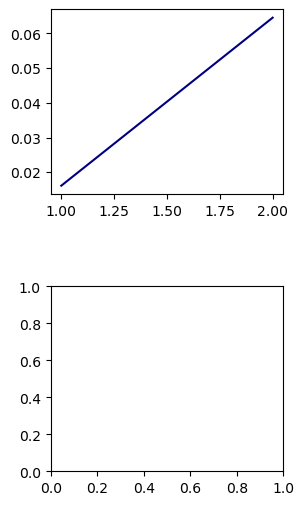

In [267]:
animals = list(day_sessions.keys())
fig,axes = plt.subplots(len(animals),1,figsize = (3,3*len(animals)))
#fig,axes = plt.subplots(2,1,figsize = (3,3*len(animals)))
plt.subplots_adjust(wspace=0.8, hspace=0.5)


row_ind = 0
for animal in animals:
    (sample1,sample2)  = ([],[])
    
    remote_num, total_num = tally_total_num(day_sessions[animal], trials[animal],proportion = proportion)
    remote_num_nearby, total_num_nearby = tally_total_num(day_sessions_nearby[animal], trials_nearby[animal],proportion = proportion)
    
    dates_to_plot = list(remote_num.keys())

    # plotting stuff
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=0, vmax=len(dates_to_plot))
    
    for d_ind in range(len(dates_to_plot)):
        d = dates_to_plot[d_ind]
        
        remote_num_day = remote_num[d]
        total_num_day = total_num[d]
        
        remote_num_nearby_day = remote_num_nearby[d]
        total_num_nearby_day = total_num_nearby[d]

        if total_num_day < 10:
            continue
    
        # rate
        rate = remote_num_day/total_num_day
        rate_nearby = remote_num_nearby_day/total_num_nearby_day
        
        axes[row_ind].plot([1,2],[rate,rate_nearby],color = cmap(norm(d_ind)),label = str(round(norm(d_ind),1)))
        #axes[row_ind,1].plot([1,2],[rate,rate_rand],color = 'k')
        #axes[row_ind,2].plot([1,2],[recent_rate,recent_rate_wouldhave],color = 'k')
        sample1.append(rate)
        sample2.append(rate_nearby)


    res = permutation_test((sample1, sample2), statistic, permutation_type="samples",vectorized=True,
                       n_resamples=10000, alternative='greater')
    

    axes[row_ind].set_xticks([1,2])
    axes[row_ind].set_xticklabels(['change of mind','nearby'],rotation = 10)
    axes[row_ind].set_ylabel('remote pct of all trials')
    axes[row_ind].set_title(' \n p value: '+str(np.round(res.pvalue,3)))  
    axes[row_ind].legend(bbox_to_anchor=(1.1, 1))

    axes[row_ind].text(0.2,axes[row_ind].get_ylim()[1],animal,fontsize = 15)
    row_ind += 1

### To inspect individual examples

In [202]:
ind = 22
animal = "Eliot"
print(day_sessions[animal][ind])
print(trials[animal][ind])
print(time_intervals[animal][ind])
print(arm_identities[animal][ind])
print(time_intervals[animal][ind][0][0][0],time_intervals[animal][ind][0][0][1])

['eliot20221021_.nwb', '04_Seq2Session2']
[[29], [38, 38, 38, 38]]
[[array([1.66638967e+09, 1.66638967e+09])], [array([1.66638989e+09, 1.66638989e+09]), array([1.66638989e+09, 1.66638989e+09]), array([1.66638989e+09, 1.66638989e+09]), array([1.66638989e+09, 1.66638989e+09])]]
[[2], [3, 4, 3, 4]]
1666389668.9683511 1666389669.0203512


In [218]:
trials_nearby[animal]

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [[64]],
 [],
 [],
 [],
 [[25, 25]],
 [],
 [],
 [],
 [],
 [[5]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [[47]],
 [],
 [],
 [[3]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [219]:
arm_identities_nearby[animal]

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [[3]],
 [],
 [],
 [],
 [[1, 1]],
 [],
 [],
 [],
 [],
 [[1]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [[4]],
 [],
 [],
 [[3]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [216]:
ind = -5
animal = "Eliot"
print(day_sessions_nearby[animal][ind])
print(trials_nearby[animal][ind])
print(time_intervals_nearby[animal][ind])
print(arm_identities_nearby[animal][ind])
print(time_intervals_nearby[animal][ind][0][0][0],
      time_intervals_nearby[animal][ind][0][0][1])

['eliot20221026_.nwb', '04_Seq2Session2']
[[9, 9, 9, 9, 9, 9]]
[[array([1.66681182e+09, 1.66681182e+09]), array([1.66681182e+09, 1.66681182e+09]), array([1.66681182e+09, 1.66681182e+09]), array([1.66681182e+09, 1.66681182e+09]), array([1.66681182e+09, 1.66681182e+09]), array([1.66681182e+09, 1.66681182e+09])]]
[[4, 4, 4, 4, 4, 4]]
1666811822.0341578 1666811822.1581578


In [249]:
day_sessions[animal]

[['haydn20230604_.nwb', '02_Rev3Session1'],
 ['haydn20230604_.nwb', '04_Rev3Session2'],
 ['haydn20230604_.nwb', '06_Rev3Session3'],
 ['haydn20230604_.nwb', '08_Rev3Session4'],
 ['haydn20230604_.nwb', '10_Rev3Session5'],
 ['haydn20230605_.nwb', '02_Rev3Session1'],
 ['haydn20230605_.nwb', '04_Rev3Session2'],
 ['haydn20230605_.nwb', '06_Rev3Session3'],
 ['haydn20230605_.nwb', '08_Rev3Session4'],
 ['haydn20230605_.nwb', '10_Rev3Session5'],
 ['haydn20230605_.nwb', '12_Rev3Session6'],
 ['haydn20230606_.nwb', '02_Rev3Session1'],
 ['haydn20230606_.nwb', '04_Rev3Session2'],
 ['haydn20230606_.nwb', '06_Rev3Session3'],
 ['haydn20230606_.nwb', '08_Rev3Session4'],
 ['haydn20230606_.nwb', '10_Rev3Session5'],
 ['haydn20230607_.nwb', '02_Rev3Session1'],
 ['haydn20230607_.nwb', '04_Rev3Session2'],
 ['haydn20230607_.nwb', '06_Rev3Session3'],
 ['haydn20230607_.nwb', '08_Rev3Session4'],
 ['haydn20230607_.nwb', '11_Rev3Session5'],
 ['haydn20230608_.nwb', '02_Rev3Session1'],
 ['haydn20230608_.nwb', '04_Rev3

In [247]:
trials[animal]

[[[47], [59]],
 [[6], [70]],
 [[38]],
 [[39]],
 [],
 [[22]],
 [[19, 19], [60]],
 [],
 [],
 [[68, 68]],
 [],
 [],
 [[37, 37]],
 [[14, 14], [26]],
 [],
 [[73]],
 [[36]],
 [],
 [],
 [],
 [[75, 75, 75]],
 [],
 [],
 [],
 [[6, 6, 6], [11], [14]],
 []]

In [250]:
arm_identities[animal]

[[[4], [2]],
 [[3], [1]],
 [[4]],
 [[2]],
 [],
 [[4]],
 [[1, 1], [2]],
 [],
 [],
 [[1, 1]],
 [],
 [],
 [[1, 1]],
 [[2, 2], [1]],
 [],
 [[2]],
 [[2]],
 [],
 [],
 [],
 [[2, 2, 2]],
 [],
 [],
 [],
 [[1, 1, 1], [3], [4]],
 []]

#### How often do the change of mind trials have representation in other arms vs the current arm?
Return proportion in time.


In [8]:
def return_remote_proportion(trials, all_snippet_info):
    remote_num = 0
    snippet_num = 0
    for snippet in trials:
        remote_num += len(snippet)
    
    for all_snippet in all_snippet_info:
        snippet_num += len(all_snippet)
        
    if snippet_num > 0:
        return remote_num/snippet_num
    else:
        return 0
    return 0

In [9]:
(triggered_positions, triggered_positions_abs,
 triggered_decodes, triggered_decodes_baseoff, triggered_decodes_abs, triggered_trial_info) = ({},{},{},{},{},{})  

animal = 'Lewis'
dates_to_plot = ['20240109','20240110']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'

(triggered_positions[animal], triggered_positions_abs[animal],
 triggered_decodes[animal], triggered_decodes_baseoff[animal], triggered_decodes_abs[animal],
 triggered_trial_info[animal]) = find_triggered_animal(animal,dates_to_plot,
                                                                   delta_t_minus = 1,delta_t_plus = 5,
                                                                   max_flag = 0, segment_only = True)

[17:30:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[17:30:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


some missing position data
currently investigating:
04_Rev2Session2
pos 3 valid times
some missing position data
some missing position data


[17:30:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times
some missing position data


[17:30:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times
some missing position data
some missing position data


[17:30:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times
some missing position data
some missing position data


[17:30:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


some missing position data
some missing position data
currently investigating:
04_Rev2Session2
pos 3 valid times
some missing position data


[17:30:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[17:30:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[17:30:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


In [11]:
within_arm_trials, inds = find_large_position_minus_decode_trials(animal, triggered_trial_info, 
                                        triggered_positions_abs, triggered_decodes_baseoff)

TypeError: find_large_position_minus_decode_trials() missing 2 required positional arguments: 'triggered_positions_baseoff_nearby' and 'triggered_decodes_baseoff_nearby'

In [133]:
len(within_arm_trials)

30

In [144]:
day

'20221026'

In [158]:
day_sessions = {}
trials = {}
time_intervals = {}
arm_identities = {}
all_snippet_info = {}

animal = 'eliot'
dates_to_plot = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

animal = 'Lewis'
dates_to_plot = ['20240102','20240103','20240104','20240105','20240106','20240107','20240108','20240109',
                 '20240110','20240113','20240114']

animal = 'Lewis'
dates_to_plot = ['20240116','20240117','20240118','20240119','20240120']

animal = 'Haydn'
dates_to_plot = ['20230604','20230605','20230606','20230607','20230608']

remote_proportion = []

for day in dates_to_plot:
    print(day)

    (day_sessions[animal],trials[animal],
     time_intervals[animal],arm_identities[animal],all_snippet_info[animal]) = find_remote_theta_animal(
        animal, [day], delta_t_minus = 1,delta_t_plus = 5, max_flag = False,
        nearby = False, # use nearby trial's outbound or inbound
        home = False
        )
    remote_prop = return_remote_proportion(trials[animal], all_snippet_info[animal])
    
    remote_proportion.append(remote_prop)

[21:22:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


20230604
haydn20230604_.nwb
currently investigating:
02_Rev3Session1
pos 1 valid times


[21:22:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times
some missing position data


[21:22:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[21:22:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times
some missing position data


[21:22:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[21:22:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times
some missing position data


[21:22:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[21:22:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times
some missing position data
some missing position data


[21:22:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[21:22:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[21:22:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


20230605
haydn20230605_.nwb
currently investigating:
02_Rev3Session1
pos 1 valid times


[21:22:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[21:22:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[21:22:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[21:22:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[21:23:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[21:23:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[21:23:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[21:23:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[21:23:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[21:23:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Rev3Session6
pos 11 valid times


[21:23:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Rev3Session6
pos 11 valid times


[21:23:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


20230606
haydn20230606_.nwb
currently investigating:
02_Rev3Session1
pos 1 valid times


[21:23:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[21:23:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[21:23:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[21:23:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[21:23:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times
some missing position data


[21:23:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[21:23:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[21:23:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[21:23:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[21:23:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


20230607
haydn20230607_.nwb
currently investigating:
02_Rev3Session1
pos 1 valid times


[21:23:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[21:23:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[21:23:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times
some missing position data


[21:23:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[21:24:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[21:24:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[21:24:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[21:24:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Rev3Session5
pos 10 valid times


[21:24:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Rev3Session5
pos 10 valid times


[21:24:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


20230608
haydn20230608_.nwb
currently investigating:
02_Rev3Session1
pos 1 valid times


[21:24:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev3Session1
pos 1 valid times


[21:24:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[21:24:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev3Session2
pos 3 valid times


[21:24:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times


[21:24:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev3Session3
pos 5 valid times
some missing position data
some missing position data


[21:24:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[21:24:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev3Session4
pos 7 valid times


[21:24:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


[21:24:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev3Session5
pos 9 valid times


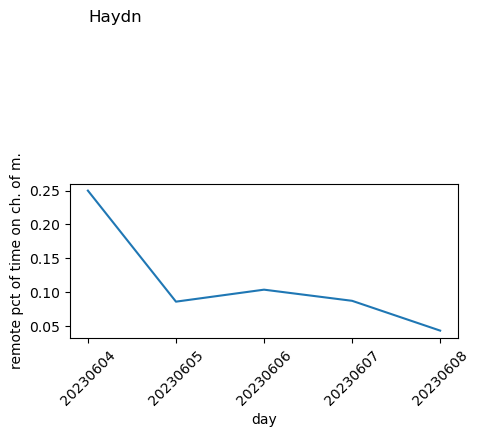

In [159]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2),sharex=True)

ax1.plot(remote_proportion)

ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('full seq occurrance pct');
ax1.set_ylabel('remote pct of time on ch. of m.');
ax1.set_xlabel('day');
ax1.set_xticks(np.arange(len(dates_to_plot)));
ax1.set_xticklabels(dates_to_plot, rotation = 45);